In [110]:
import detection_utils
from importlib import reload
from imutils import contours
import numpy as np
import matplotlib.pyplot as plt
import cv2

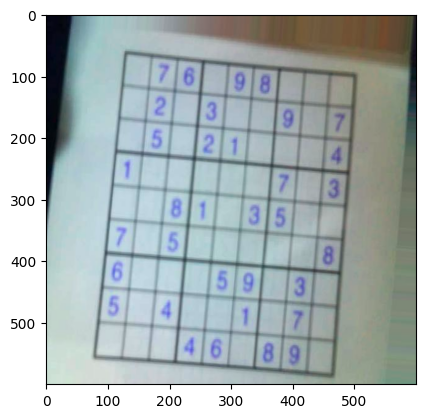

In [113]:
image = cv2.imread('./data/original/images/1021_1739541260.4181554.jpg')
plt.imshow(image)

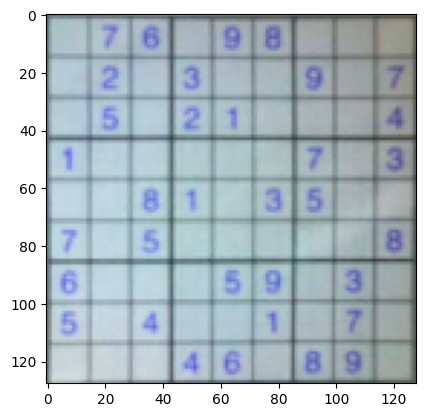

In [137]:
image = detection_utils.detect_and_warp(image)
plt.imshow(image)

In [ ]:
def extract_cells(image):
    #estimate cell area
    h,w,c = image.shape
    image_area = h * w
    approx_cell_area = image_area / 81
    row_area = approx_cell_area * 9

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
    # Filter out all numbers and noise to isolate only boxes
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < approx_cell_area:
            cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

    # Fix grid lines
    kernel = np.ones(shape=(5,5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Sort by top to bottom and each row by left to right
    invert = 255 - thresh
    cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

    sudoku_rows = []
    row = []
    for (i, c) in enumerate(cnts, 1):
        area = cv2.contourArea(c)
        if area < 5000:
            row.append(c)
            if i % 9 == 0:  
                (cnts, _) = contours.sort_contours(row, method="left-to-right")
                sudoku_rows.append(cnts)
                row = []

    # Initialize the 9x9 grid array
    sudoku_grid = np.zeros((9, 9, 28, 28), dtype=np.uint8)

    # Extract each cell and resize
    for r, row in enumerate(sudoku_rows):
        for c, cell in enumerate(row):
            x, y, w, h = cv2.boundingRect(cell)
            cell_image = gray[y:y+h, x:x+w]  # Crop cell
            cell_image = cv2.resize(cell_image, (28, 28))  # Resize to 28x28
            sudoku_grid[r, c] = cell_image  # Store in grid

    return sudoku_grid  # Shape (9,9,28,28)

In [170]:
grid = extract_cells(image)

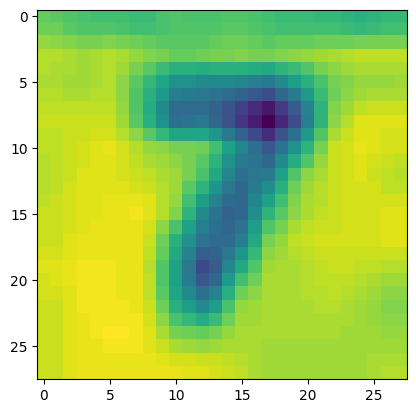

In [171]:
plt.imshow(grid[0,1])

Prediction: [5], Confidence: [0.6818164]


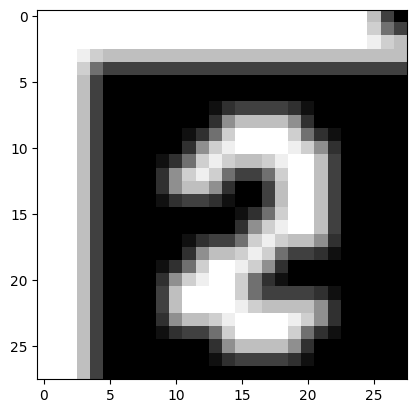

In [106]:
import inference_classiffier
from importlib import reload
reload(inference_classiffier)
image = grid_cells[1][1]
pred,confidence, probs = inference_classiffier.classify_digit(image)
print(f'Prediction: {pred}, Confidence: {confidence}')
plt.imshow(image,cmap='gray')

In [26]:
pred

array([5], dtype=int64)